# Object masks in images from prompts with SAM 2

In [70]:
from mask_maker import *

import rawpy
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve

In [71]:
def load_image_raw(path):
    """
    Charge une image RAW et retourne les données brutes du capteur
    sous forme de tableau numpy.
    """
    with rawpy.imread(path) as raw:
        raw_data = raw.raw_image_visible.copy().astype(np.float32)
        rgb = raw.postprocess(output_bps=16, no_auto_bright=True, use_camera_wb=True)
    return raw_data, rgb/65535.0

class raw_image:
    def __init__(self, path):
        self.raw_data, self.metadata = load_image_raw(path)


def demosaic_bilinear(raw_array):
    """
    Dématriçage bilinéaire simple d'un RAW Bayer RGGB.
    Retourne une image RGB numpy (H, W, 3).
    """
    h, w = raw_array.shape
    raw_array = raw_array.astype(np.float32)

    # Création des masques R, G, B
    R = np.zeros((h, w), dtype=np.float32)
    G = np.zeros((h, w), dtype=np.float32)
    B = np.zeros((h, w), dtype=np.float32)

    # Pattern RGGB
    R[0::2, 0::2] = raw_array[0::2, 0::2]
    G[0::2, 1::2] = raw_array[0::2, 1::2]
    G[1::2, 0::2] = raw_array[1::2, 0::2]
    B[1::2, 1::2] = raw_array[1::2, 1::2]

    # Noyaux bilinéaires pour interpolation
    kernel_RB = np.array([[0.25, 0.5, 0.25],
                          [0.5 , 1.0, 0.5 ],
                          [0.25, 0.5, 0.25]], dtype=np.float32)
    kernel_G = np.array([[0, 0.25, 0],
                         [0.25, 1.0, 0.25],
                         [0, 0.25, 0]], dtype=np.float32)

    # Convolution pour interpolation
    R_interp = convolve(R, kernel_RB, mode='mirror')
    G_interp = convolve(G, kernel_G, mode='mirror')
    B_interp = convolve(B, kernel_RB, mode='mirror')

    # Normalisation (optionnelle, dépend de la plage de valeurs du RAW)
    R_interp /= np.max(R_interp)
    G_interp /= np.max(G_interp)
    B_interp /= np.max(B_interp)

    # Empilement final en float32
    rgb = np.stack((R_interp, G_interp, B_interp), axis=-1).astype(np.float32)

    return rgb


def show_raw_and_bilinear(raw_array):
    """
    Affiche :
    - à gauche : RAW brut (Bayer)
    - à droite : dématriçage bilinéaire simple
    """
    rgb = demosaic_bilinear(raw_array)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    axes[0].imshow(raw_array, cmap='gray')
    axes[0].set_title("RAW brut (Bayer)")
    axes[0].axis("off")

    axes[1].imshow(rgb / rgb.max())
    axes[1].set_title("Dématriçage bilinéaire simple")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

In [72]:
path_S = "./BDD/Reel/Buddha_4/Stray/DSC_9646.NEF"
S, rgb_S = load_image_raw(path_S)

path_SL = "./BDD/Reel/Buddha_4/Stray&PS/DSC_9653.NEF"
SL, rgb_SL = load_image_raw(path_SL)

L_pred = SL - S


In [73]:
path_L = "./BDD/Reel/Buddha_4/PS/DSC_9505.NEF"
L_true, rgb_L_true = load_image_raw(path_L)

L_err = L_true - L_pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.69067985..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12113433..1.0].


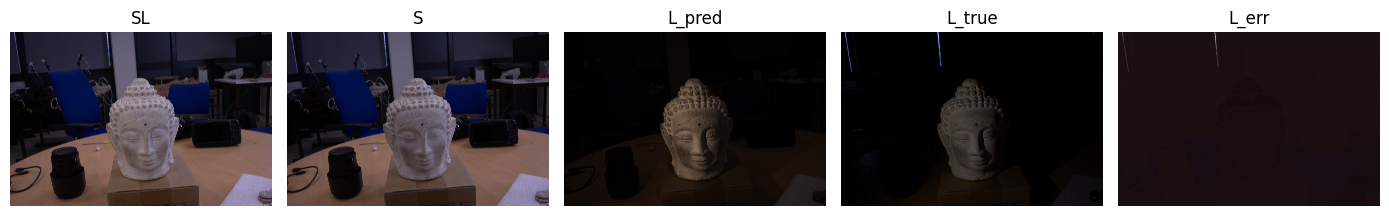

In [78]:
# Afficher en rgb les images SL S L_pred L_true :
fig, axes = plt.subplots(1, 5, figsize=(14, 6))

axes[0].imshow(rgb_SL)
axes[0].set_title("SL")
axes[0].axis("off")

axes[1].imshow(rgb_S)
axes[1].set_title("S")
axes[1].axis("off")

axes[2].imshow(demosaic_bilinear(L_pred))
axes[2].set_title("L_pred")
axes[2].axis("off")

axes[3].imshow(rgb_L_true)
axes[3].set_title("L_true")
axes[3].axis("off")

axes[4].imshow(demosaic_bilinear(L_err))
axes[4].set_title("L_err")
axes[4].axis("off")

plt.tight_layout()
plt.show()